# 2. Adding services to the simulation

Service is a key component to the simulation that defines a running scenario for your experiment.
Each service has access to peer class and Simpy environment. 

At the moment simulation has two abstract service classes: 
1. Runner  
2. Handler


### **Runner**

Runner works as a producer of events, or when you require an action initiative from a peer. For example, a message producer is a runner.

Function to implement: `run()`


### **Handler**

Handler works as a reactive service that handles incoming messages. 

Functions to implement: 
 - `handle_message(msg)` - react upon recieving a message.
 - `@property messages` - list of messages that this service can handle.  


For example, a connection manager is both a runner and a handler as it produces and reacts on messages. 



# Creating new services


The simulation at this point is not very useful. 
Let's create our own service on top of what we have now, i.e. let's build a gossip network.


A gossip protocol ([wiki](https://en.wikipedia.org/wiki/Gossip_protocol)) is an important building block used in almost any P2P system(for example: [hyperledger gossip](https://hyperledger-fabric.readthedocs.io/en/release-1.4/gossip.html), [course slides](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf)). 


## Gossip Message Handler

There are multiple ways to implement Gossip: [ttl, anti-entropy etc](http://www.cs.cornell.edu/Projects/Quicksilver/public_pdfs/2007PromiseAndLimitations.pdf).

We will implement one of the simplest versions based on ttl (Time to live), where each message has a predefined $ttl$ parameter. $ttl$ shows a stoping condition for the peer, i.e. if $ttl$=0, the peer should stop, otherwise $ttl$ must be decremented and the message should be gossiped further.

Let's first implement a handler: a service that reacts on incoming gossip messages: 


In [1]:
# Message gossip
from p2psimpy import *
from p2psimpy.services.base import BaseHandler
from p2psimpy.messages import BaseMessage
from p2psimpy.storage import Storage

from re import split 
from copy import copy

# Define a special message GossipMessage: Message with ttl
class GossipMessage(BaseMessage):

    __slots__ = ('sender', 'data', 'ttl')
    size = 1024
    
    def __init__(self, sender, data, ttl):
        super().__init__(sender, data)
        self.ttl = ttl
        
class GossipService(BaseHandler):
    """
    A simple gossip service to handle the gossip messages and pass them to the neighbors. 
    """

    def __init__(self, peer, fanout=3, exclude_peers: set=None, exclude_types: set=None):
        super().__init__(peer)
        
        self.fanout = fanout
        if exclude_peers is None:
            self.exclude_peers = set() 
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types
        
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())

    def handle_message(self, msg):
        # Store message localy 
        msg_id = msg.data
        # Store the message id received with the current timestamp
        self.peer.store(self.strg_name, msg_id, self.peer.env.now)
        if msg.ttl > 0:
            # Rely message further, modify the message
            exclude_peers = {msg.sender} | self.exclude_peers
            # Use peer gossip - it will sample self.config.fanout and exclude sender
            # If you need to exclude some peers: add it to the set
            self.peer.gossip( GossipMessage(self.peer, msg.data, msg.ttl-1), 
                             self.fanout, except_peers=exclude_peers, except_type=self.exclude_types)

    @property
    def messages(self):
        return GossipMessage,


The Peer object has a gossip function that will send a message to a random sample of `fanout` connected peers.
Peers are included in `except_peers` and `except_type` are excluded from the sampling. 


The service implements a reaction on the messages specified in the `messages` property and reacts as follows: 
- Peer stores the message when it is received and keeps the timestamp when the message was received - `self.peer.env.now`. Note also that to store the message first we need to initilize it via `self.peer.add_storage(storage_name, storage_object)`. 
- If the message ttl is positive, the peer sends the message to the `fanout` number of random connected peers with a function `self.peer.gossip(Msg, fanout)`. You can also exclude some peers from the sampling like excluding the sender of the message (from which you get the message) is a reasonable optimization. 





## Message producer 

Finally, we need to create a service that will first create (produce) the message. 
We will inherit a MessageProducer from a `BaseRunner` class.

MessageProducer will have `msg_rate`, `ttl`, `fanout` and a `timeout_delay`.




In [2]:
from p2psimpy.services.base import BaseRunner

class MessageProducer(BaseRunner):

    def __init__(self, peer, init_timeout=1000, msg_rate=5, init_ttl=3, init_fanout=10):
        '''
        init_timeout: milliseconds to wait before starting the message production. 
        msg_rate: number of messages per second
        init_ttl: ttl to set up for the message 
        init_fanout: to how many peer send the message to
        '''
        super().__init__(peer)

        # calculate tx_interval
        self.init_timeout = init_timeout
        self.init_ttl = init_ttl
        self.init_fanout = init_fanout
        
        self.tx_interval = 1000 / msg_rate
        self.counter = 1 
        
        # Let's add a storage layer to store messages
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())


    def produce_transaction(self):
        # Create a gossip message: message counter, peer_id and gossip it   
        self.peer.gossip(GossipMessage(self.peer,
                                       '_'.join((str(self.counter), str(self.peer.peer_id))), 
                                       self.init_ttl), 
                         self.init_fanout)
        # Locally store the message counter 
        self.peer.store(self.strg_name, str(self.counter), self.peer.env.now)
        self.counter+=1
        

    def run(self):
        # Wait the initial timeout
        yield self.env.timeout(self.init_timeout)
        while True:
            self.produce_transaction()
            yield self.env.timeout(self.tx_interval)

Notice that `yield time_to_wait` is used to simulate time and waiting in a simulation. 

-----

## Preparing an Experiment

In [3]:
# Define locations 
from p2psimpy.config import *
from p2psimpy.consts import *
from p2psimpy.services.connection_manager import BaseConnectionManager
import networkx as nx
from random import choice

import matplotlib.pyplot as plt

# We take the locations from AWS 
class Locations(Config):
    locations = ['Ohio', 'Ireland', 'Tokyo']
    latencies = {
        'Ohio': {'Ohio': Dist('invgamma', (5.54090, 0.333305, 0.987249)),
                 'Ireland': Dist('norm', (73.6995, 1.19583092197097127)),
                 'Tokyo': Dist('norm', (156.00904977375566, 0.09469886668079797))
                },
        'Ireland':{'Ireland': Dist('invgamma', (6.4360455224301525, 0.8312748033308526, 1.086191852963273)),
                   'Tokyo': Dist('norm', (131.0275, 0.25834811785650774))
                  },
        'Tokyo': {'Tokyo':  Dist('invgamma', (11.104508341331055, 0.3371934865734555, 2.0258998705983737))}
    }
    
# Define peer     
class PeerConfig(Config):
    location = Dist('sample', Locations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Configuration used for our GossipService
class GossipConfig(Config):
    exclude_types={'client',}

# We have not two types of nodes: *peer* and *client*
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, (BaseConnectionManager, MessageProducer))}

def prepare_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, 0.4)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

def visualize_peer_client_network(G):
    plt.figure(figsize=(10,10))

    # Draw client/ peer network 

    master_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=100, label=1)

    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w')

    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted')


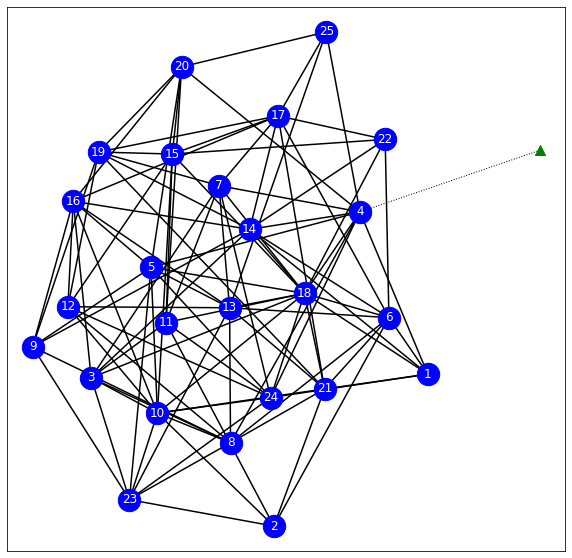

In [4]:
# Prepare and show target network topology 
G = prepare_topology()
visualize_peer_client_network(G)

In [5]:
from time import time
from p2psimpy.simulation import BaseSimulation

net_sim = BaseSimulation(Locations, G, prepare_peer_types())

+


In [6]:

net_sim.run(5_200)


One of the main properties that we need to achieve with gossip is **convergence**.
**Convergence** is a state where every peer has received the required message. 
The gossip protocols are compared with each other using the **time to convergence** metric.


We can find it by inspecting the time when peer has the received message by looking at `peer.storage`.
For this experiment we used a simple dictionary - *first-seen* storage. 

In [7]:
client_id = 26
print("Time when message was produced by the client: \n", net_sim.peers[client_id].storage['msg_time'].txs)

# Put any peer id you want to inspect
peer_id = 1 

print("Time when the message was received by the peer: \n", net_sim.peers[peer_id].storage['msg_time'].txs)

Time when message was produced by the client: 
 {'1': 1000, '2': 1200.0, '3': 1400.0, '4': 1600.0, '5': 1800.0, '6': 2000.0, '7': 2200.0, '8': 2400.0, '9': 2600.0, '10': 2800.0, '11': 3000.0, '12': 3200.0, '13': 3400.0, '14': 3600.0, '15': 3800.0, '16': 4000.0, '17': 4200.0, '18': 4400.0, '19': 4600.0, '20': 4800.0, '21': 5000.0}
Time when the message was received by the peer: 
 {'2_26': 1315.2187955683228, '3_26': 1514.2236366678067, '4_26': 1715.4392818759727, '5_26': 1914.9456214747056, '6_26': 2115.0671968350657, '9_26': 2715.156719058779, '10_26': 2915.134707118176, '11_26': 3245.047583781845, '13_26': 3515.9819640405703, '14_26': 3713.7390001813824, '15_26': 3939.3734963502557, '16_26': 4139.769454832993, '18_26': 4515.354449993482, '19_26': 4715.091213140117, '20_26': 4915.126707617623}


In [8]:
# Calculate the delay 

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
dict(total_delay(net_sim, peer_id, 'msg_time'))

{2: 115.21879556832278,
 3: 114.22363666780666,
 4: 115.43928187597271,
 5: 114.9456214747056,
 6: 115.06719683506572,
 9: 115.15671905877889,
 10: 115.13470711817581,
 11: 245.04758378184488,
 13: 115.98196404057035,
 14: 113.73900018138238,
 15: 139.37349635025566,
 16: 139.76945483299278,
 18: 115.35444999348238,
 19: 115.09121314011736,
 20: 115.12670761762274}

In [9]:
dict(total_delay(net_sim, 12, 'msg_time'))

{1: 75.00536495146844,
 3: 179.6953723061597,
 4: 74.44442921968925,
 5: 74.20961863252933,
 6: 181.19248738796387,
 7: 75.18623018854169,
 8: 73.92308086172534,
 9: 180.74350338961995,
 11: 73.6735213105394,
 12: 73.78459821910337,
 13: 231.82051907003142,
 14: 73.76419666972106,
 15: 180.9133946030538,
 17: 74.0896230053022,
 18: 74.57504843656261,
 19: 180.3070887062695,
 20: 73.90849267602061,
 21: 180.49896130433535}

### Exercise

Try to play around with different peer_id values. Try peer that is directly connected to the client, then try peer that is on the edge of the network.

Try the same with an emergent topology.

In [10]:
# peer 4 is directly connected to client
peer_id = 4
dict(total_delay(net_sim, peer_id, 'msg_time'))

{1: 36.632141663429366,
 2: 37.1781273433312,
 3: 36.201519978926854,
 4: 36.88362515736071,
 5: 36.754188045519186,
 6: 37.0079136989732,
 7: 36.95842316664448,
 8: 36.521241750131594,
 9: 37.10384559099339,
 10: 36.951010781267996,
 11: 36.30152139197071,
 12: 36.180063469753804,
 13: 38.03695688391508,
 14: 35.672076719602956,
 15: 37.07187947222428,
 16: 36.82522399924164,
 17: 36.369730160086874,
 18: 37.06856472387517,
 19: 36.864785131738245,
 20: 36.536511964237434,
 21: 36.67835182479212}

In [11]:
# peer 25 is on the edge
peer_id = 25
dict(total_delay(net_sim, peer_id, 'msg_time'))

{3: 109.99154614633176,
 4: 111.46632974319118,
 5: 37.19017302143516,
 6: 37.250048013162996,
 7: 193.17724552799928,
 9: 37.33537145425862,
 11: 192.59301480653994,
 12: 36.4354178950739,
 16: 110.8628750107182,
 17: 36.69581183054015,
 18: 112.64031718499609,
 21: 36.91147503225238}

+


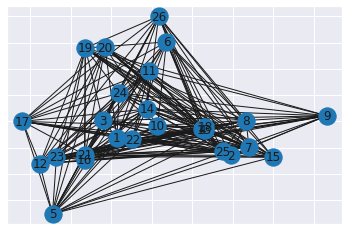

In [35]:
# define an emergent topology. Configureation is from the first assignment
from p2psimpy.services.connection_manager import P2PConnectionManager

num_peers = 26

topology_specs = {i:{'type': 'peer'} for i in range(1, num_peers)}
topology_specs[26] = {'type': 'client'}
def prepare_emergent_peer_types():
    return { 'peer': PeerType(PeerConfig,   {P2PConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, (P2PConnectionManager, MessageProducer))}
class ConnectionConfig(Config):
    min_peers = 2
    max_peers = 4

# peer_types = {'basic': PeerType(PeerConfig, {P2PConnectionManager: ConnectionConfig})}
sim_emergent = BaseSimulation(Locations, topology_specs, prepare_emergent_peer_types())

# Let's run the simulation for 5 seconds
sim_emergent.run(5_000)
G1 = sim_emergent.get_graph()
nx.draw_networkx(G1)

In [36]:
# peer 19 is directly connected to client

peer_id = 19
dict(total_delay(sim_emergent, peer_id, 'msg_time'))

{2: 36.65042938242868,
 3: 36.34251133114799,
 4: 143.4636858122592,
 5: 143.59684611430953,
 6: 37.89288481032327,
 7: 37.25306792864376,
 8: 36.99885742988499,
 9: 36.64346543207057,
 10: 36.95903850873219,
 11: 36.87950708497101,
 12: 37.45279503518577,
 13: 36.48492994972048,
 14: 35.50380081898038,
 15: 36.98092068539654,
 16: 36.89810411425424,
 17: 36.46463758103437,
 18: 35.66177044564665,
 19: 35.92535839688935,
 20: 37.11233136831106}

In [38]:
# peer 9 is on the edge
peer_id = 9
dict(total_delay(sim_emergent, peer_id, 'msg_time'))

{4: 131.13022568061137,
 5: 131.5190824273675,
 6: 74.38915182844312,
 7: 74.1133756858967,
 8: 73.8652712110088,
 9: 73.94181969248848,
 10: 73.03346385844998,
 11: 74.37249850264789,
 12: 74.00373460511537,
 13: 73.10575765475596,
 14: 73.10293873409773,
 15: 0.9744503636511581,
 16: 72.57811991441622,
 17: 73.4221861916285,
 18: 1.607823753822231,
 19: 73.02552502785238,
 20: 72.34776107589005}

In [40]:
# In genneral, the node connected to client has much shorted delay. 
net_sim.save_experiment(expr_dir='gossip_expr/0')
sim_emergent.save_experiment(expr_dir='gossip_expr/1')

____________________________

# Analyze and visualize  gossip


When implementing gossip it is important to analyze following: 
 - What is the average time for the peer to receive a message? 
 - What is the convergence speed for my gossip protocol? 
 - Can we guarantee that all peers will see the message? At what time message is finalized?   


Let's go one by one and answer these questions for this gossip protocol implementation. 


## Convergence

In [12]:
import pandas as pd

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
def get_gossip_table(sim, storage_name):
    return pd.DataFrame({k: dict(total_delay(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()
df = get_gossip_table(net_sim, 'msg_time')
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,NaN,75.135121,180.232482,36.632142,192.882727,139.467540,114.606133,115.132062,114.868934,75.207014,...,115.135295,75.073902,74.040810,73.245859,NaN,74.618746,114.887378,115.118333,NaN,NaN
2,115.218796,75.623697,75.159136,37.178127,37.463714,115.466833,115.696767,140.897814,115.788490,75.642321,...,115.693516,181.124612,74.614748,230.401990,NaN,75.114770,271.318243,115.524880,37.700014,NaN
3,114.223637,179.949427,NaN,36.201520,110.311865,114.430507,NaN,114.184770,NaN,NaN,...,114.679195,74.104133,74.097236,180.173930,73.047971,179.729221,NaN,188.265775,217.050964,109.991546
4,115.439282,180.733533,180.868386,36.883625,37.155247,NaN,NaN,114.836018,115.106678,180.357742,...,115.361096,75.073004,75.145993,75.086825,74.133385,180.127167,NaN,115.203686,37.463982,111.466330
5,114.945621,NaN,180.435838,36.754188,108.847335,139.861616,NaN,NaN,115.183223,146.913823,...,115.472920,74.400825,73.073577,74.723007,73.822309,180.369823,188.219770,114.942648,37.000399,37.190173
6,115.067197,NaN,180.935340,37.007914,109.804673,245.973979,115.047605,115.546187,NaN,181.032222,...,139.389759,74.111180,180.441444,74.616379,73.296798,180.701990,139.736072,NaN,193.059471,37.250048
7,NaN,NaN,74.059193,36.958423,218.020935,115.207760,114.911590,114.942918,NaN,74.694761,...,115.543072,NaN,73.541278,NaN,180.639283,75.230005,115.455394,115.209855,37.227450,193.177246
8,NaN,NaN,74.134464,36.521242,192.695828,138.998917,115.000474,NaN,114.711919,73.860410,...,114.962672,NaN,73.397913,73.766619,73.675867,NaN,139.793886,115.035352,36.769313,NaN
9,115.156719,180.978081,180.646283,37.103846,112.522687,115.439288,115.122550,115.644155,NaN,NaN,...,246.417380,73.931386,180.734112,74.476378,74.830143,74.424236,115.682343,NaN,193.267530,37.335371
10,115.134707,180.787413,180.197792,36.951011,NaN,NaN,115.011683,NaN,139.572890,74.610200,...,115.177325,74.601317,73.810742,73.948985,73.497728,180.570347,139.345129,NaN,NaN,NaN


Code above should produce a table with the message number on the rows and peer id on the columns. 

You can also probably see `NaN` values in the table. These indicate that the gossip protocol didn't fully converge, and some peers never saw some messages. To guarantee convergence we either need to implement a gossip based on [set reconciliation](https://www.cse.ust.hk/~yike/sigmod14.pdf)  or tweak the parameters: `fanout` and `ttl`. We need to fine-tune the parameter to achieve the required effect. 

Usually gossip is fast to converge, but depends on the network topology. 

We can also represent our table as a heatmap. White color corresponds to `Nan`. You can see what peers are slower, or what message is least/most seen:

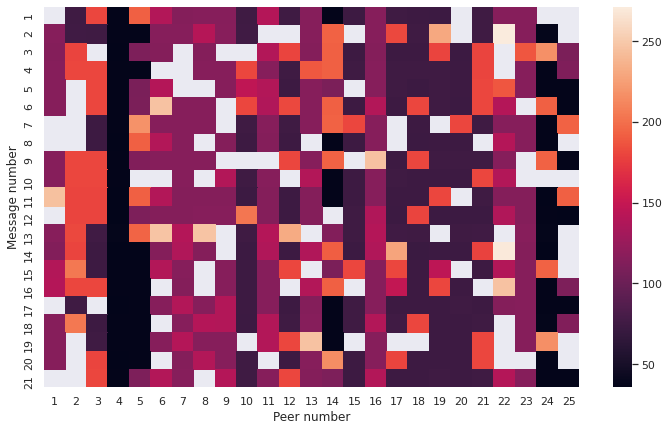

In [13]:
import seaborn as sns
sns.set()

def show_heat_map(df):
    plt.figure(figsize=(12, 7))
    ax = plt.axes()

    sns.heatmap(df, ax=ax)

    plt.xlabel('Peer number', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Message number', fontsize = 12) # y-axis label with fontsize 15

    plt.show()

show_heat_map(df)

## Average time 

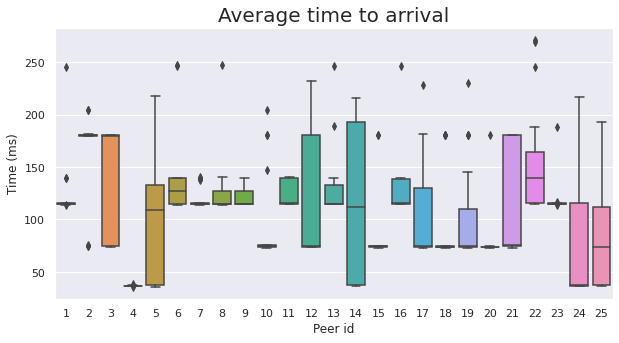

In [14]:
def show_avg_time(df):
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(data=df, )
    ax.set_title('Average time to arrival', fontsize= 20 )
    ax.set_ylabel('Time (ms)', fontsize=12)
    ax.set_xlabel('Peer id', fontsize=12)
    plt.show()
show_avg_time(df)

## Convergence speed

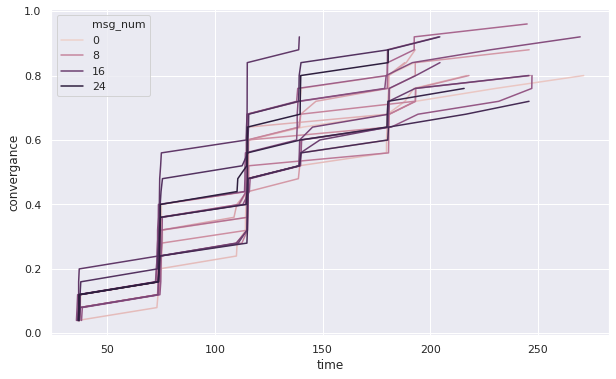

In [15]:
def conv(df):
    num_peers = len(df.columns)
    num_messages = len(df.index)
    
    
    a = df.values
    a.sort(axis=1)
    df2 = pd.DataFrame(a)
 

    df2.columns = ((i+1)/num_peers for i in df2.columns)
    df2.index = pd.RangeIndex(start=1, stop=num_messages+1, step=1)

    return df2.stack().reset_index().rename(columns={'level_0':'msg_num', 'level_1':'convergance', 0: 'time'})

def show_convergence(df):
    plt.figure(figsize=(10,6))
    sns.lineplot(x='time', y='convergance', data=conv(df), ci='sd', estimator="median", hue='msg_num')
    
show_convergence(df)

## Overhead on peers 

Each gossip creates an overhead for peers. 


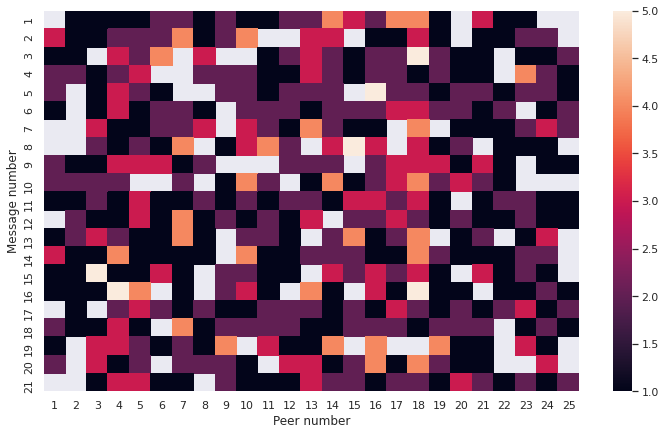

In [16]:
def calc_overhead(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].times_seen
    for k, times in store.items():
        msg_num, client_id = k.split('_')
        yield (int(msg_num), int(times))
    
def get_overhead_table(sim, storage_name):
    return pd.DataFrame({k: dict(calc_overhead(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()

oh = get_overhead_table(net_sim, 'msg_time')
show_heat_map(oh)            

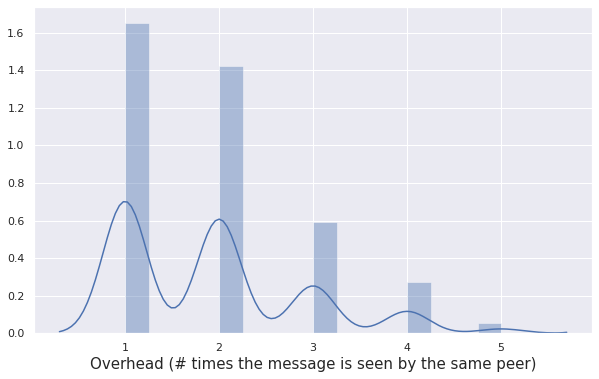

In [17]:
# Show average overhead on message
def show_overhead_hist(overhead_table):
    plt.figure(figsize=(10, 6))
    sns.distplot(overhead_table, norm_hist=True)
    plt.xlabel('Overhead (# times the message is seen by the same peer)', fontsize=15)

show_overhead_hist(oh)




# Achieving full convergence 


This is an exploratory section where you have one task: **full convergence**.

As it is clear from our gossip protocol, full convergence is not possible with this set of parameter configuration. What can we do to achieve it? 

Possible options: 

1. Tweak parameter of gossip protocol. Change `ttl` and `fanout`. But keep in mind that it will increase the load on the network. As our gossip protocol is blind, it might take a lot of resources to guarantee convergence. Also, `ttl` and `fanout` highly depend on the network topology. Try to change that and find out what the optimal `ttl` is as a function of the number of peers?     
2. Change the network topology. What is an optimal topology for convergence?  
3. Implement better gossip protocols. We were using a naive gossip, but there better variations based on [rumor-mongering and anti-entropy](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf). A good start will be change gossip protocol to *pull-based* instead of *push-based*. 




Report for your gossip protocol: 
- If it achieves convergence. 
- Convergence speed.
- Average time to convergence.
- The overhead on peers. 


Report your findings: 
- How can you improve your gossip protocol further? 
- Try to change the topology? Can you still achieve convergence? 
- How big is the overhead on peers? How can you improve it? 



In [ ]:
# 1. change parameters of gossip protocol


In [18]:
# we define a function to provide analysis

import statistics

def analyse_net(net):    
    num_peers = len(net.types_peers['peer'])
#     print("number of peers:")
#     print(num_peers)
    num_disconnected_nodes = 0
    time_list = []
    for k in net_sim.types_peers['peer']:
#         print(k)
        tmp_dict = dict(total_delay(net, k, 'msg_time')) 
        num_connected_nodes = len(tmp_dict.keys())
        if len(tmp_dict.keys()) <= 25:
            num_disconnected_nodes += (25 - num_connected_nodes)
            for tmp_key in tmp_dict.keys():
                time_list.append(tmp_dict[tmp_key])
#     print("number of disconnected peers in total:")
#     print(num_disconnected_nodes)
    if len(time_list) != 0:
        return num_disconnected_nodes, sum(time_list)/len(time_list), statistics.median(time_list)
    else:
        return 0, 0, 0
#     print(k, dict(total_delay(net_sim, k, 'msg_time')))

In [42]:
# An example of convergence process
sim_0 = BaseSimulation(Locations, G, prepare_peer_types())

time_range = 25
for t in range(2, time_range+1):
    print("time: %d" % t)
    sim_0.run(str(t) + "_000")
    res = analyse_net(sim_0)
    if res[0] == 0:
        print("network converged")
        break
    else:
        print("number of disconnected peers in total: %d" % res[0])
        print("average of delay: %f" % res[1])
        print("median of delay: %f" % res[2])
    print("============")

+
time: 2
number of disconnected peers in total: 519
average of delay: 126.783197
median of delay: 103.122886
time: 3
number of disconnected peers in total: 416
average of delay: 124.649714
median of delay: 103.358161
time: 4
number of disconnected peers in total: 311
average of delay: 123.540204
median of delay: 103.359387
time: 5
number of disconnected peers in total: 209
average of delay: 123.630734
median of delay: 103.314697
time: 6
number of disconnected peers in total: 106
average of delay: 121.636004
median of delay: 103.194561
time: 7
number of disconnected peers in total: 53
average of delay: 144.160750
median of delay: 168.060015
time: 8
number of disconnected peers in total: 37
average of delay: 140.364115
median of delay: 167.451514
time: 9
number of disconnected peers in total: 26
average of delay: 145.269228
median of delay: 167.776524
time: 10
number of disconnected peers in total: 15
average of delay: 161.331599
median of delay: 168.751745
time: 11
number of disconnect

In [45]:
# Convergence speed with different ttl, the default setting is 3. 
# We only change ttl while keeping ohter parameters the same
# Generally, increasing ttl would accelerate the convergence process,but
# it will also dratically increase the time to run it. Based on the results,
# ttl = 4 is the best parameter 
import time
ttl_list = [4,6,8,10]
for new_ttl in ttl_list:
    start = time.time()
    sim_1 = BaseSimulation(Locations, G, prepare_peer_types())
    sim_1.peers[26].runners['MessageProducer'].init_ttl = new_ttl
    time_range = 25
    for t in range(2, time_range+1):
#         print(t)
        sim_1.run(str(t) + "_000")
        res = analyse_net(sim_1)
        if res[0] == 0:
            end = time.time()
            print("ttl is %d, network converged at %d, time cost: %f" % (new_ttl, t, (end-start)))
            print("============")
            break



+
ttl is 4, network converged at 7, time cost: 0.455070
+
ttl is 6, network converged at 7, time cost: 1.993504
+
ttl is 8, network converged at 6, time cost: 14.041749
+
ttl is 10, network converged at 6, time cost: 140.956979


In [48]:
# Convergence speed with different fanout, the default setting is 10. 
# We only change fanout while keeping ohter parameters the same
# Generally, increasing fanout would not change the convergence process much, because
# the topology of network is fixed. Based on the results,
# the default setting is the best parameter 
import time
fanout_list = [5,10,15,20]
for new_fanout in fanout_list:
    start = time.time()
    sim_2 = BaseSimulation(Locations, G, prepare_peer_types())
    sim_2.peers[26].runners['MessageProducer'].init_fanout = new_fanout
    time_range = 25
    for t in range(2, time_range+1):
#         print(t)
        sim_2.run(str(t) + "_000")
        res = analyse_net(sim_2)
        if res[0] == 0:
            end = time.time()
            print("fanout is %d, network converged at %d, time cost: %f" % (new_fanout, t, (end-start)))
            print("============")
            break



+
fanout is 5, network converged at 15, time cost: 0.839316
+
fanout is 10, network converged at 12, time cost: 0.382417
+
fanout is 15, network converged at 13, time cost: 0.420286
+
fanout is 20, network converged at 12, time cost: 0.387682


In [20]:
# 2. change the network topology
# We define a new function for changing topology
def new_topology(num_peers=25, num_clients=1, prob=0.4):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, prob)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

In [54]:
# Convergence speed with different topology, the default probability for possible 
# edges is 0.4  
# We only change probability while keeping ohter parameters the same
# Generally, increasing probability  would generate more edges and bring more 
# connections. Therefore, the convergence speed is faster with a larger probability.
# Based on the results, prob = 0.6 is the best parameter 
import time
prob_list = [0.2,0.5,0.6,0.8]
for new_prob in prob_list:
    start = time.time()
    G2 = new_topology(prob=new_prob)
    sim_3 = BaseSimulation(Locations, G2, prepare_peer_types())
#     sim_3.peers[26].runners['MessageProducer'].init_ttl = new_ttl
    time_range = 25
    for t in range(2, time_range+1):
        sim_3.run(str(t) + "_000")
        res = analyse_net(sim_3)
        if res[0] == 0:
            end = time.time()
            print("prob is %f, network converged at %d, time cost: %f" % (new_prob, t, (end-start)))
            print("============")
            break

+
prob is 0.200000, network converged at 13, time cost: 0.426570
+
prob is 0.500000, network converged at 11, time cost: 0.598206
+
prob is 0.600000, network converged at 9, time cost: 0.561582
+
prob is 0.800000, network converged at 9, time cost: 1.075157


In [58]:
# Convergence speed with different number of peers, the default number is 25 
# We only change number of peers while keeping ohter parameters the same
# Generally, increasing number of peers  would need more time for network to
# converge.
import time
peer_num_list = [30,40,50,60]
for peer_num in peer_num_list:
    start = time.time()
    G3 = new_topology(num_peers=peer_num)
    sim_4 = BaseSimulation(Locations, G3, prepare_peer_types())
#     sim_3.peers[26].runners['MessageProducer'].init_ttl = new_ttl
    time_range = 25
    for t in range(2, time_range+1):
        sim_4.run(str(t) + "_000")
        res = analyse_net(sim_4)
        if res[0] == 0:
            end = time.time()
            print("peer number is %f, network converged at %d, time cost: %f" % (peer_num, t, (end-start)))
            print("============")
            break

+
peer number is 30.000000, network converged at 11, time cost: 0.663885
+
peer number is 40.000000, network converged at 18, time cost: 1.703843
+
peer number is 50.000000, network converged at 14, time cost: 2.464871
+
peer number is 60.000000, network converged at 15, time cost: 3.479948


In [61]:
# Convergence speed with different number of clients, the default number is 1
# We only change number of clients while keeping ohter parameters the same
# Generally, simply increasing number of clients could not consisitently accelerating
# the convergence speed.
import time
client_num_list = [2,4,6,8,10]
for peer_num in client_num_list:
    start = time.time()
    G4 = new_topology(num_clients=peer_num)
    sim_5 = BaseSimulation(Locations, G4, prepare_peer_types())
    time_range = 25
    for t in range(2, time_range+1):
        sim_5.run(str(t) + "_000")
        res = analyse_net(sim_5)
        if res[0] == 0:
            end = time.time()
            print("client number is %d, network converged at %d, time cost: %f" % (peer_num, t, (end-start)))
            print("============")
            break

+
client number is 2, network converged at 16, time cost: 0.928859
+
client number is 4, network converged at 6, time cost: 0.445470
+
client number is 6, network converged at 6, time cost: 0.611812
+
client number is 8, network converged at 6, time cost: 0.690832
+
client number is 10, network converged at 6, time cost: 0.884686


In [26]:
# define a new type of message with parameter to cotrol probability

class NewGossipMessage(GossipMessage):
    def __init__(self, sender, data, ttl, k):
        super().__init__(sender, data)
        self.ttl = ttl
        self.k = k

In [29]:
# We set a threshold for probability. It is based on the pull service from repository

class MessageResponder(BaseHandler):
    def _form_message_response(self, msg):
        response = {}
        for k in msg.data:
            response[k] = self.peer.get_storage('msg_data').get(k)
        return response
    def handle_message(self, msg):
        self.peer.send(msg.sender, MsgResponse(
            self.peer, self._form_message_response(msg)))
    @property
    def messages(self):
        return MsgRequest,

class NewGossipService(MessageResponder, BaseRunner):

    def __init__(self, peer,
                 exclude_types: set = None, exclude_peers: set = None,
                 fanout=10, prob_threshold=0.1,
                 init_timeout=Dist('norm', (200, 100))):
        super().__init__(peer)
        self.fanout = fanout
        if exclude_peers is None:
            self.exclude_peers = set()
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types

        self.sync_time = 200
        self.peer.add_storage('msg_time', Storage())
        self.peer.add_storage('msg_data', Storage())       
        self.strg = self.peer.get_storage('msg_data')
        self.ini_time = abs(Cache(init_timeout).fetch())

    def run(self):
        yield self.env.timeout(self.ini_time)
        while True:
            yield self.env.timeout(self.sync_time)
            self.peer.gossip(SyncPing(self.peer, self.strg.txs.keys()), self.fanout,
                             except_peers=self.exclude_peers, except_type=self.exclude_types)

    def _store_message(self, msg, msg_id=None):
        if not msg_id:
            msg_id = msg.id
        self.peer.store('msg_time', msg_id, self.peer.env.now)
        self.peer.store('msg_data', msg_id, msg)

    def handle_message(self, msg):
        if type(msg) == GossipMessage:
            self._store_message(msg)
            if 1/(k+1) > self.prob_threshold:
                exclude_peers = {msg.sender} | self.exclude_peers
                self.peer.gossip(NewGossipMessage(self.peer, msg.data, msg.k+1, 1), 
                                 self.fanout, except_peers=exclude_peers, except_type=self.exclude_types)
        elif type(msg) == SyncPing:
            known = self.strg.txs.keys()
            peer_missing = set(known) - set(msg.data)
            me_missing = set(msg.data) - set(known)
            if len(peer_missing) > 0:
                self.peer.send(msg.sender, SyncPong(self.peer, peer_missing))
            if len(me_missing) > 0:
                self.peer.send(msg.sender, MsgRequest(self.peer, me_missing))
        elif type(msg) == SyncPong:
            known = self.strg.txs.keys()
            me_missing = set(msg.data) - set(known)
            if len(me_missing) > 0:
                self.peer.send(msg.sender, MsgRequest(self.peer, me_missing))
        elif type(msg) == MsgRequest:
            MessageResponder.handle_message(self, msg)
        elif type(msg) == MsgResponse:
            for k, v in msg.data.items():
                self._store_message(v, k)

    @property
    def messages(self):
        return NewGossipMessage, SyncPing, SyncPong, MsgRequest, MsgResponse
    
    
class InitMessageConfig(Config):
    init_ttl= 4  
    
def new_peer_types():
    
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                NewGossipService: GossipConfig }),
             'client': PeerType(PeerConfig, (BaseConnectionManager, MessageProducer))}


In [24]:

sim_8 = BaseSimulation(Locations, G, new_peer_types())
time_range = 25
for t in range(2, time_range+1):
    sim_8.run(str(t) + "_000")
    res = analyse_net(sim_8)
    if res[0] == 0:
#         end = time.time()
        print("network converged at %d" % t)
        print("============")
        break

+
network converged at 7


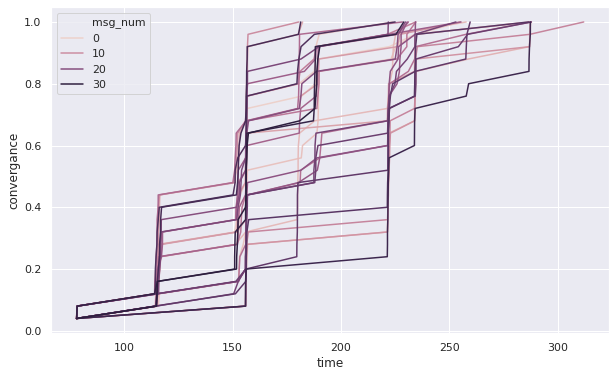

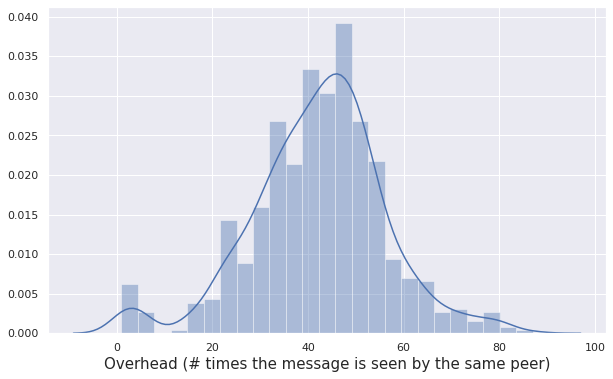

In [25]:
df8 = get_gossip_table(sim_8, 'msg_time')
show_convergence(df8)
oh8 = get_overhead_table(sim_8, 'msg_time')
show_overhead_hist(oh8)

In [134]:
def new_total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].get_storage(storage_name).txs
    for k, peer_time in store.items():
        client_id, msg_num = k.split('_')
        client_id = int(client_id)
        msg_num = int(msg_num)
        client_time = sim.peers[client_id].storage[storage_name].txs[k]
        yield (int(msg_num), peer_time - client_time)

def new_analyse_net(net):    
    num_peers = len(net.types_peers['peer'])
#     print("number of peers:")
#     print(num_peers)
    num_disconnected_nodes = 0
    time_list = []
    for k in net_sim.types_peers['peer']:
#         print(k)
        tmp_dict = dict(new_total_delay(net, k, 'msg_time')) 
        num_connected_nodes = len(tmp_dict.keys())
        if len(tmp_dict.keys()) <= 25:
            num_disconnected_nodes += (25 - num_connected_nodes)
            for tmp_key in tmp_dict.keys():
                time_list.append(tmp_dict[tmp_key])
#     print("number of disconnected peers in total:")
#     print(num_disconnected_nodes)
    if len(time_list) != 0:
        return num_disconnected_nodes, sum(time_list)/len(time_list), statistics.median(time_list)
    else:
        return 0, 0, 0

In [168]:
net_sim.save_experiment(expr_dir='gossip_expr/final')

Finally, for reproducibility you can save the experiment data. Use `.save_experiment(dir)` to save configurations for your experiment to a `dir` directory: locations, topology and peer services.  Whole experiment will be saved in yaml files. As they are saved in human readable format, you can always open and read the experiment configurations.

By default, it will not save the reference to implementations as it is not always [safe to do](https://github.com/yaml/pyyaml/wiki/PyYAML-yaml.load(input)-Deprecation). But if you are confident enough that other notebooks can find the service implementation feel free to use `include_module_classes=True`. 

For example, `GossipService` and `MessageProducer` cannot be saved as they are defined only within the scope of one notebook. If you want to include also implementations of services make sure to save them first somewhere where other notebooks can find it, e.g. to save into `py` file in `p2psimpy.services` module. 

In [71]:
# net_sim.save_experiment(expr_dir='gossip_expr')